In [36]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

from pymc_extras.statespace.core.statespace import PyMCStateSpace

In [37]:
matrix_names = [
    "initial_state",
    "initial_state_cov",
    "state_intercept",
    "obs_intercept",
    "transition",
    "design",
    "selection",
    "obs_cov",
    "state_cov",
]


def print_model_ssm(mod, how="eval"):
    nice_heading = f"{'name':<20}{'__repr__':<50}{'shape':<10}{'value':<20}"
    print(nice_heading)
    print("=" * len(nice_heading))
    if how == "eval":
        matrices = [x.eval() for x in mod._unpack_statespace_with_placeholders()]
    elif how == "draw":
        matrices = pm.draw(mod.unpack_statespace())

    for name, value in zip(matrix_names, matrices):
        repr_ = str(mod.ssm[name])
        shape = str(mod.ssm[name].type.shape)
        value = str(value).replace("\n ", "\n" + " " * 81)
        print(f"{name:<20}{repr_:<50}{shape:<10}{value:<20}")
        print("-" * len(nice_heading))

In [38]:
seed = sum(map(ord, "custom statespace model"))
rng = np.random.default_rng(seed)

# Why use the `PyMCStateSpace` class

The statespace module is designed to make it easy for users to create their own statespace models. At its core, a statspace model is just a system of two linear equatons:

$$\begin{align} x_{t} &= A_t x_{t-1} + c_t + R_t \varepsilon_t, & \varepsilon_t &\sim N(0, Q_t) \\
y_t &= Z_t x_t + d_t + \eta_t, & \eta_t &\sim N(0, H_t) \\
x_0 &\sim N(\bar x, P)\end{align}$$

Despite just being 2 equations (plus an inital state distribution), there is a need for some machinery to abstract away the matrices, and let users focus on parameters when modeling. As an example, here is an AR(3) model in statespace form:

$$\begin{align} \begin{bmatrix} x_t \\ x_{t-1} \\ x_{t-2} \end{bmatrix} &= \begin{bmatrix} \rho_1 & \rho_2 & \rho_3 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix} \begin{bmatrix} x_{t-1} \\ x_{t-2} \\ x_{t-3} \end{bmatrix} + \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix} \varepsilon_t, & \varepsilon_t &\sim N \left (0, \begin{bmatrix}\sigma^2_x\end{bmatrix} \right) \\
 y_t &= \begin{bmatrix} 1 & 0 & 0 \end{bmatrix} \begin{bmatrix}x_t \\ x_{t-1} \\ x_{t-2} \end{bmatrix} \end{align}$$
 
Although the model has only 4 parameters, $\theta = \begin{bmatrix} \rho_1 & \rho_2 & \rho_3 & \sigma^2_x \end{bmatrix}$, there is a good amount of additional "structure" that needs to be dealt with. The parameters need to be slotted into the correct locations in $T$ and $Q$, constants need to be inserted into $T$, $R$, and $Z$, and the fact that $\eta_t$ is not present needs to be handled.

These details present a significant learning curve for a user, who just wants to estimate 4 parameters and model some data. The purpose of the `PyMCStateSpace` class is to protect users from these messy details, and allow them to put their focus where it belongs.


# Making a new `PyMCStateSpace` model

Nevertheless, if you want to make your own spacespace model, the `PyMCStateSpace` class is designed to allow users to easily implement new models. A subclass of `PyMCStateSpace` **must** overload 3 important methods/properties:

1. `__init__`.
2. `param_names`
3. `make_symbolic_graph`

In addition to these 3, there are several additional properties that can be implemented. These are optional, and are related to automatically generating coords and dims for a PyMC model. They include:

4. `param_info`
5. `state_names`
6. `observed_states`
7. `shock_names`
8. `coords`
9. `param_dims`

We will return to these optional properties later in the notebook. First, let's see what you **must** do to make a statespace model by implementing the AR(3) model described above.

## The AutoRegressiveThree class

The first thing to implement is the `__init__` method. The main purpose of the `__init__` method is create two supporting objects and attach them to your `PyMCStateSpace`. The first is a `PytensorRepresentation` object, and the second is a `KalmanFilter`. 

* The `PytensorRepresentation` is attached to your statepace as `ssm` (for "State Space Model"). It holds all the vectors and matrices associated with your statespace. 
    * In order to initialize all these objects, the `PytensorRepresentation` needs to know their shapes. Three numbers define all the shapes of all the objects in the system: `k_states`, `k_posdef`, and `k_endog`. 
        * `k_states` is the total number of hidden states in the system -- that's the shape of the $x_t$ vector. In our case, it's 3.
        * `k_posdef` is the total number of shock processes in the system. It's called "posdef" for "positive definite", because it refers to the rank of the matrix $RQR^T$ (which is the covariance matrix of $\varepsilon_t$ if you ues the rule of affine transformations of multivariate normals). Anyway, it's 1 in our case.
        * `k_endog` is the total number of observed variables -- that's the shape of the $y_t$ vector. In our case it's 1.      
* The `KalmanFilter` is a recursive algorithm that infers the values of the hidden states and the probably of the data. You can pass a keyword argument `filter_type` to `super().__init__()` to get different types of filters, but the default works great.

Our model isn't going to have any bells or whistles, so we just hard-code the three shape arguments and pass them to the superclass constructor. 

### The `__init__` method

In [39]:
class AutoRegressiveThree(PyMCStateSpace):
    def __init__(self):
        k_states = 3  # size of the state vector x
        k_posdef = 1  # number of shocks (size of the state covariance matrix Q)
        k_endog = 1  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        # We will implement this in a moment. For now, we need to overwrite it with nothing to avoid a NotImplementedError
        # when we initialize a class instance.
        pass

This already works, and we can look at the `PytensorRepresentation` and `KalmanFilter` that have been created for us.

In [40]:
ar3 = AutoRegressiveThree()

In [41]:
ar3.ssm

In [42]:
ar3.kalman_filter

To see indivdual matrices inside the `PytensorRepresentation`, you ask for them by name. The matrix names are:

* $\bar x$ - `initial_state`
* $P$ - `initial_state_cov`
* $c$ - `state_intercept`
* $d$ - `obs_intercept`
* $T$ - `transition`
* $Z$ - `design`
* $R$ - `selection`
* $H$ - `obs_cov`
* $Q$ - `state_cov`

In [43]:
print_model_ssm(ar3)

name                __repr__                                          shape     value               
initial_state       initial_state{[0. 0. 0.]}                         (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov{[[0. 0. 0. ... 0. 0. 0.]]}      (3, 3)    [[0. 0. 0.]
                                                                                 [0. 0. 0.]
                                                                                 [0. 0. 0.]]
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (1,)      [0.]                
----------------

As you can see, all of the matrices have the right shapes, but they're initialized with a bunch of zeros. Getting parameters into these matrices in the right positions is the role of the `make_symbolic_graph` method, which we have not implemented yet. So we just get back the defaults.

Referring back to the equations above, we need to put `1` into some locations of `transition`, `selection`, and `design`. This is very easy to do: after providing a matrix name, you are allowed to index into a matrix and set values by using direct assignment, just like a normal numpy array.

In [44]:
ar3.ssm["transition", :, :] = np.eye(3, k=-1)
ar3.ssm["selection", 0, 0] = 1
ar3.ssm["design", 0, 0] = 1

In [45]:
print_model_ssm(ar3)

name                __repr__                                          shape     value               
initial_state       initial_state{[0. 0. 0.]}                         (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov{[[0. 0. 0. ... 0. 0. 0.]]}      (3, 3)    [[0. 0. 0.]
                                                                                 [0. 0. 0.]
                                                                                 [0. 0. 0.]]
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (1,)      [0.]                
----------------

As you can see, values were assigned in all the matrices, as expected. Let's go back and edit the class to do this on construction

In [46]:
class AutoRegressiveThree(PyMCStateSpace):
    def __init__(self):
        k_states = 3  # size of the state vector x
        k_posdef = 1  # number of shocks (size of the state covariance matrix Q)
        k_endog = 1  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        self.ssm["transition", :, :] = np.eye(3, k=-1)
        self.ssm["selection", 0, 0] = 1
        self.ssm["design", 0, 0] = 1

Now everything intializes correctly.

In [47]:
ar3 = AutoRegressiveThree()
print_model_ssm(ar3)

name                __repr__                                          shape     value               
initial_state       initial_state{[0. 0. 0.]}                         (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov{[[0. 0. 0. ... 0. 0. 0.]]}      (3, 3)    [[0. 0. 0.]
                                                                                 [0. 0. 0.]
                                                                                 [0. 0. 0.]]
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (1,)      [0.]                
----------------

### The `make_symbolic_graph` method

After `__init__`, the second thing we need to do is implement the `make_symbolic_graph` property. This method is a critical bridge between a PyMC model and a PyMCStateSpace model. To understand why, we need to take a look at where we are going to go.

The `build_statespace_graph` method of a `PyMCStateSpace` instance is called inside a `pm.Model` block. Calling this method will do several things:

1. Register the observed data that will be used to perform Kalman Filtering.
2. Call the `_insert_random_variables` method, which re-writes the graphs associted with all statespace matrices, swapping out `pytensor` symbolic variables for `PyMC` random variable.
3. Unpack all the statespace matrices and kalman filter outputs into `pm.Determistic` variables so they are stored in posterior `InferenceData`.
4. Create an observed distribution using the registered data, and compute the log likelihood of the data under the model.

Before `build_statespace_graph` can call `_insert_random_variables,` we need to tell it where the random variables go. To do this, we use pytensor symbolic variables. For each parameter in the model, we need to:

1. Create a pytensor variable
2. "register" the variable in the `_name_to_variable` attribute, which maps the name of a variable to the particular pytensor variable that represents it
3. Put the variable where it belongs in the matrices

There is a helper function, `make_and_register_variable`, to help you do steps (1) and (2) at the same time. You just have to tell it the name and the shape of the parameter. One other thing `make_and_register_variabe` does is force you to be consistent in parameter naming. All parameter names **must** be registered in a class property called `param_names`. So we'll add that in too.



Let's see how this all looks in action:

In [48]:
class AutoRegressiveThree(PyMCStateSpace):
    def __init__(self, mode: str):
        k_states = 3  # size of the state vector x
        k_posdef = 1  # number of shocks (size of the state covariance matrix Q)
        k_endog = 1  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef, mode=mode)

    def make_symbolic_graph(self):
        x0 = self.make_and_register_variable("x0", shape=(3,))
        P0 = self.make_and_register_variable("P0", shape=(3, 3))
        ar_params = self.make_and_register_variable("ar_params", shape=(3,))
        sigma_x = self.make_and_register_variable("sigma_x", shape=())

        self.ssm["transition", :, :] = np.eye(3, k=-1)
        self.ssm["selection", 0, 0] = 1
        self.ssm["design", 0, 0] = 1

        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0
        self.ssm["transition", 0, :] = ar_params
        self.ssm["state_cov", :, :] = sigma_x

    @property
    def param_names(self):
        return ["x0", "P0", "ar_params", "sigma_x"]

In addition to the two parameters the model needs (`ar_params` for $\rho_1, \rho_2, \rho_3$, and `\sigma_x` for $sigma_x$), I also decided to force the user provide random variables for the initial state and covariance. Of course, we can also provide deterministic values via `pm.Determisitic` too. 

As promised, all the variables we created were registered in this `_name_to_variable` attribute. If we had tried to create a parameter that isn't among the `param_names`, we would have gotten an error. This forces your model to be consistent, and is especially important when we get to the "bells and whistles" section below.

In [49]:
ar3 = AutoRegressiveThree(mode="NUMBA")
ar3._name_to_variable

{'x0': x0, 'P0': P0, 'ar_params': ar_params, 'sigma_x': sigma_x}

Going back to the list of things that `build_statespace_graph` does, `make_symbolic_graph` is what allows step 2 to happen. The names returned by the property `param_names` will be sought out in the `pm.Model` currently on the context stack. For each name in `param_names`, `_insert_random_variables` (which is called by `build_statespace_graph`) will ask if that name is associated with a random variable in the model. If it's not, an error will be raised. If it is, a new mapping, `_name_to_variable[name]:pymc_model[name]`, will be created. The statespace matrices are then re-written, removing all the symbolic variables and putting the random variables in their place.

Let's see it all in action. 

In [50]:
ar3 = AutoRegressiveThree(mode="NUMBA")
with pm.Model() as mod:
    x0 = pm.Deterministic("x0", pt.arange(3, dtype="float"))
    P0 = pm.Deterministic("P0", pt.eye(3) * 10.0)
    ar_params = pm.Deterministic("ar_params", pt.as_tensor_variable([10.0, 11.0, 12.0]))
    sigma_x = pm.Deterministic("sigma_x", pt.as_tensor_variable(13.0, dtype="float64"))
    ar3._insert_random_variables()

Nothing happens right away, but we now have access to a new class method: `unpack_statespace`:

In [51]:
matrices = ar3.unpack_statespace()
len(matrices)

9

To prove these really have the RVs in them, we can take a "random" draw and see that the deterministic values we set in the `pm.Model` context ended up where we expected:

In [52]:
print_model_ssm(ar3, "draw")

name                __repr__                                          shape     value               
initial_state       initial_state                                     (3,)      [0. 1. 2.]          
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov                                 (3, 3)    [[10.  0.  0.]
                                                                                 [ 0. 10.  0.]
                                                                                 [ 0.  0. 10.]]
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (1,)      [0.]                
-------

Also, if no RV for a given `param_name` is found, an error will be raised. The names have to match exactly, and all names need to be present. 

In [53]:
ar3 = AutoRegressiveThree(mode="NUMBA")
with pm.Model() as mod:
    x0 = pm.Deterministic("x0", pt.arange(3))
    #     P0 = pm.Deterministic('P0', pt.eye(3) * 10)
    ar_params = pm.Deterministic("ar_params", pt.as_tensor_variable([10, 11, 12]))
    sigma_x = pm.Deterministic("sigma_x", pt.as_tensor_variable([13]))

    try:
        ar3._insert_random_variables()
    except ValueError as e:
        print(e)

The following required model parameters were not found in the PyMC model: P0


## Putting everything together

We are now ready to call `build_statespace_graph` inside a PyMC model block to estimate our AR(3) model. To do so we need some data, though. For now I'll just use some dummy data.

In [54]:
ar3 = AutoRegressiveThree(mode="NUMBA")
data = np.full((100, 1), np.nan)
with pm.Model() as pymc_mod:
    x0 = pm.Deterministic(
        "x0",
        pt.zeros(
            3,
        ),
    )
    P0 = pm.Deterministic("P0", pt.eye(3) * 10)

    ar_params = pm.Normal("ar_params", sigma=0.25, shape=(3,))
    sigma_x = pm.Exponential("sigma_x", 1)

    ar3.build_statespace_graph(data=data)

/Users/jessegrabowski/Documents/Python/pymc_extras/pymc_extras/statespace/utils/data_tools.py:175: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)


As you can see, everything has been updated and we're ready to go!

In [55]:
print_model_ssm(ar3, "draw")

name                __repr__                                          shape     value               
initial_state       initial_state                                     (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov                                 (3, 3)    [[10.  0.  0.]
                                                                                 [ 0. 10.  0.]
                                                                                 [ 0.  0. 10.]]
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (1,)      [0.]                
-------

# Generate Data

Let's draw a trajectory from the model's unconditional dynamics to use as fake data

In [56]:
with pymc_mod:
    prior = pm.sample_prior_predictive(compile_kwargs={"mode": "NUMBA"}, random_seed=rng)

Sampling: [ar_params, obs, sigma_x]


In [57]:
uncond_prior = ar3.sample_unconditional_prior(prior, steps=100, random_seed=rng)
prior_obs = uncond_prior.prior_observed.stack(sample=["chain", "draw"])

# Take only the non-explosive samples
stationary_samples = prior_obs.isel(
    sample=(np.abs(prior_obs).max(dim=["prior_observed_dim_0"]) < 10).values[0]
)

Sampling: [prior_combined]


Output()

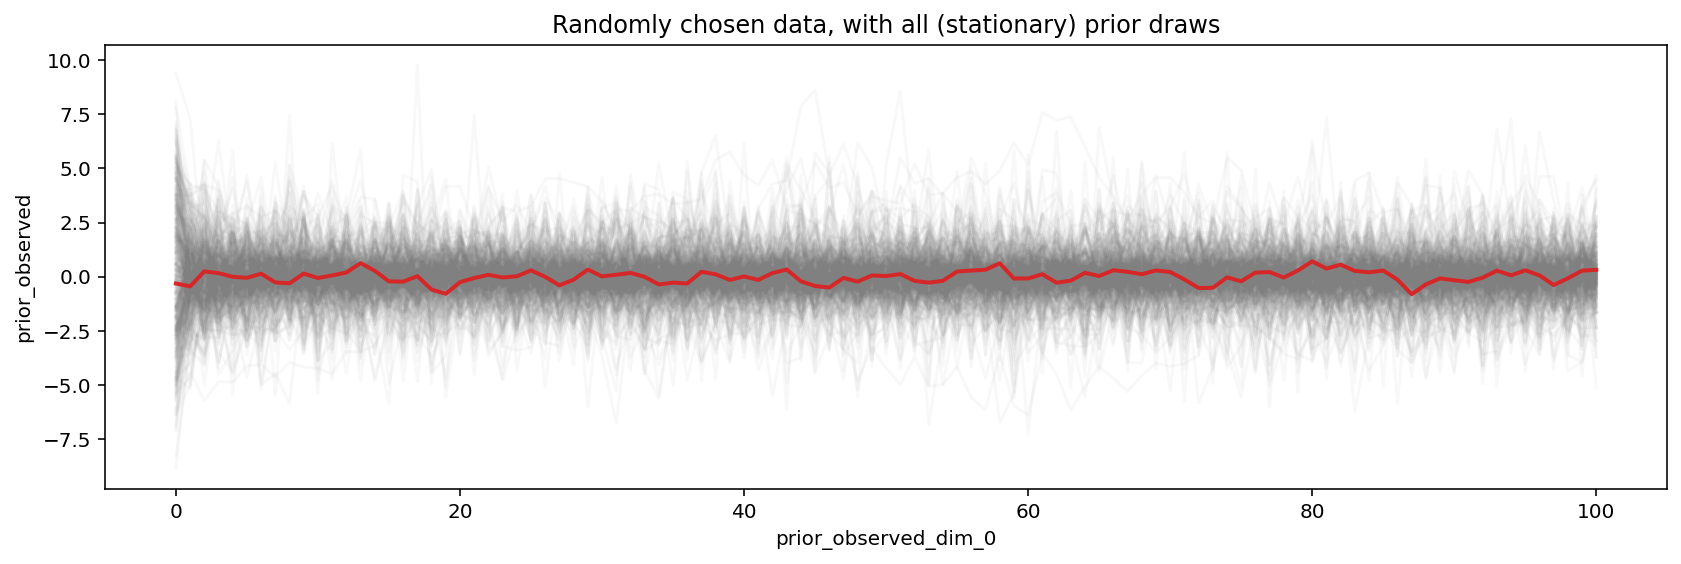

In [58]:
# Choose a sample to model at random from the non-explosive ones
data_idx = rng.choice(stationary_samples.coords["sample"].draw.values)
data = stationary_samples.sel(chain=0, draw=data_idx).values

fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
(
    stationary_samples.sel(prior_observed_dim_1=0).plot.line(
        x="prior_observed_dim_0", add_legend=False, ax=ax, color="0.5", alpha=0.05
    )
)
ax.plot(data, color="tab:red", lw=2)
ax.set_title("Randomly chosen data, with all (stationary) prior draws")
plt.show()

In [59]:
# Save the true AR parameters and sigma_x to see how well we do recovering them
true_ar = prior.prior.ar_params.sel(chain=0, draw=data_idx).values
true_sigma_x = prior.prior.sigma_x.sel(chain=0, draw=data_idx).values

## Fit the custom AR3 model

In [60]:
ar3 = AutoRegressiveThree(mode="NUMBA")

with pm.Model() as pymc_mod:
    # We could estimate x0 and P0 if we wanted, but let's just set them to reasonable values and
    # not worry about it
    x0 = pm.Data(
        "x0",
        np.zeros(
            3,
        ),
    )
    P0 = pm.Data("P0", np.eye(3) * 10)

    ar_params = pm.Normal("ar_params", sigma=0.25, shape=(3,))
    sigma_x = pm.Exponential("sigma_x", 1)

    ar3.build_statespace_graph(data=data)
    idata = pm.sample(
        nuts_sampler="pymc",
        compile_kwargs={"mode": "NUMBA"},
        cores=8,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [ar_params, sigma_x]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


<Axes: >

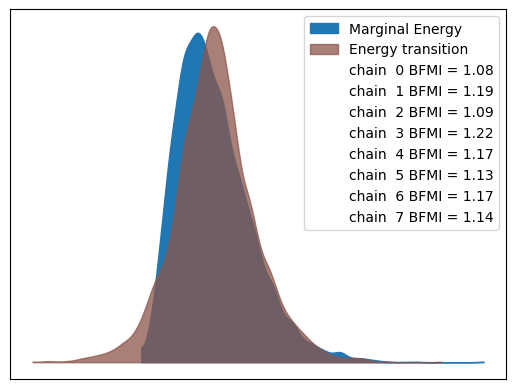

In [61]:
az.plot_energy(idata)

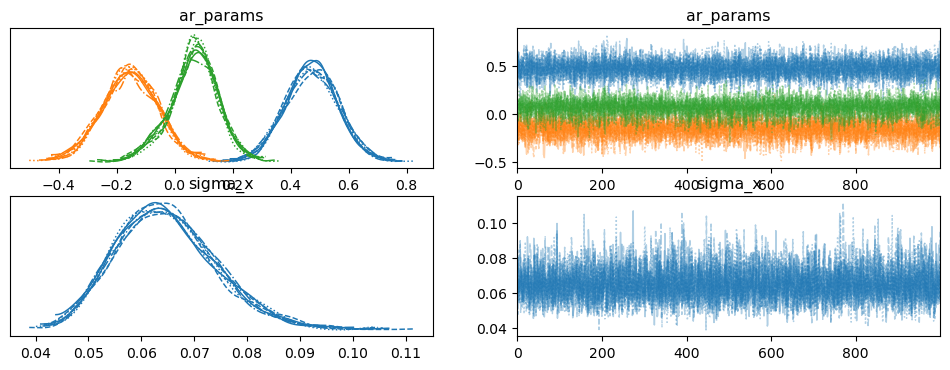

In [62]:
az.plot_trace(idata, var_names=["ar_params", "sigma_x"]);

Estimation goes well, and we recover the true parameters. Just like that!

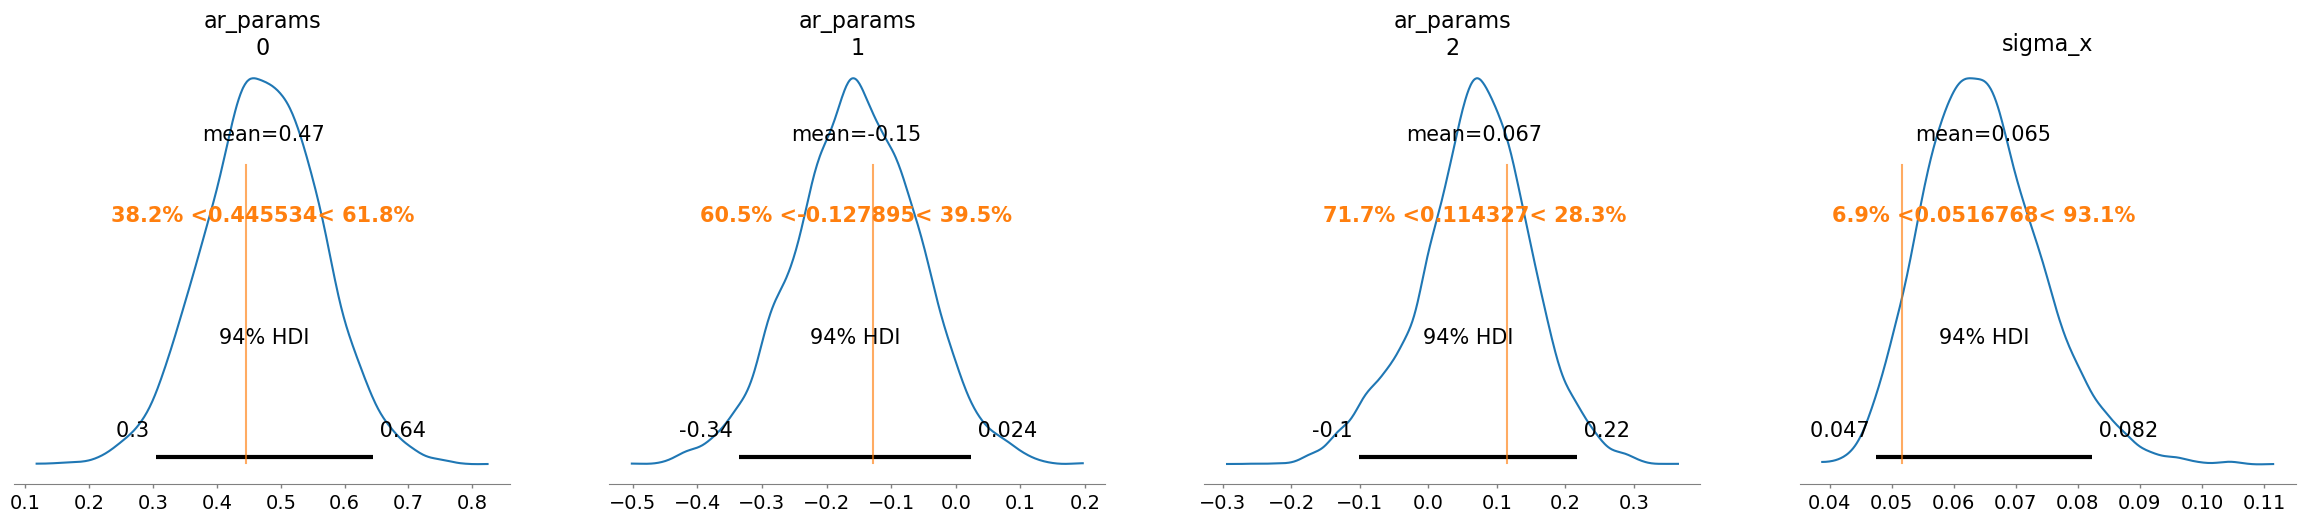

In [63]:
az.plot_posterior(
    idata, var_names=["ar_params", "sigma_x"], ref_val=[*true_ar.tolist(), true_sigma_x]
);

## Bells and Whistles

So creating a statespace model is really that simple. All you **need** to do is implement the `__init__` method, `param_names` property, and `update` method.

That said, there are some extra bells and whistles you can optionally set up as well. These are used to set dims and coords on your PyMC model. If you look at the idata we get back from the estimation exercise above, it's pretty horrible. Every statespace object has its own dims, which really makes things look messy.

In [64]:
list(idata.posterior.coords.keys())

['chain', 'draw', 'ar_params_dim_0']

In fact, among all these dimensions, there are only 4 dimensions:

1. states
2. observed states
3. shocks
4. time

To let the model know that, we can set the `state_names`, `observed_states`, and  `shock_names` properties. The `param_dims` property maps the names of params to dimensions. Finally, the `coords` property returns a `dims:coords` dictionary for PyMC to use.

The last thing we can implement is the `params_info` property. If it exists, it will be used to show a message after a model is instantiated, telling the user what the param names are, what their shapes are, and any support restrictions the priors need to respect.

Here is the `AutoRegressiveThree` class one last time, with all the bells and whistles implemented.

In [65]:
from pymc_extras.statespace.core.properties import (
    Parameter,
    State,
    Shock,
    Coord,
)
from pymc_extras.statespace.utils.constants import ALL_STATE_DIM, ALL_STATE_AUX_DIM, SHOCK_DIM

In [66]:
class AutoRegressiveThree(PyMCStateSpace):
    def __init__(self, mode: str):
        k_states = 3  # size of the state vector x
        k_posdef = 1  # number of shocks (size of the state covariance matrix Q)
        k_endog = 1  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef, mode=mode)

    def make_symbolic_graph(self):
        x0 = self.make_and_register_variable("x0", shape=(3,))
        P0 = self.make_and_register_variable("P0", shape=(3, 3))
        ar_params = self.make_and_register_variable("ar_params", shape=(3,))
        sigma_x = self.make_and_register_variable("sigma_x", shape=(1,))

        self.ssm["transition", :, :] = np.eye(3, k=-1)
        self.ssm["selection", 0, 0] = 1
        self.ssm["design", 0, 0] = 1

        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0
        self.ssm["transition", 0, :] = ar_params
        self.ssm["state_cov", :, :] = sigma_x

    def set_parameters(self):
        # Only the "name" parameter is required here. "Shape" is only used when printing the
        # model requirements table. "Dims" are used to link variables to coords.
        x0 = Parameter(name="x0", shape=(3,), dims=(ALL_STATE_DIM,))
        P0 = Parameter(name="P0", shape=(3, 3), dims=(ALL_STATE_DIM, ALL_STATE_AUX_DIM))
        ar_params = Parameter(
            name="ar_params", shape=(3,), dims=("ar_lags",), constraints="Stationary, please :)"
        )
        sigma_x = Parameter(name="sigma_x", shape=(1,), dims=(SHOCK_DIM,))
        return x0, P0, ar_params, sigma_x

    def set_states(self):
        # To get a name on the observed, we make an observed state
        data = State(name="data", observed=True)

        # Since the three hidden states are lags of the data, i'll call them L1, L2 L3
        L1 = State(name="L1.data", observed=False)
        L2 = State(name="L2.data", observed=False)
        L3 = State(name="L3.data", observed=False)

        return data, L1, L2, L3

    def set_shocks(self):
        # There is one shock, called the "innovations" in the literature, so i'll go with that
        innovation = Shock(name="innovations")
        return innovation

    def set_coords(self):
        # This function sets up the coords dictionary used by pm.Model. The parent class has a helper
        # self.default_coords() that makes the coords that are always expected by a statespace model --
        # stuff like state, shock, etc.

        # You need to give one Coord object per dimension used among the Parameter objects you made a

        default_coords = self.default_coords()
        ar_coord = Coord(dimension="ar_lags", labels=(1, 2, 3))
        return *default_coords, ar_coord

Now when we create an `AutoRegressiveThree` model, we get a message telling us how to declare the priors:

In [67]:
ar3 = AutoRegressiveThree(mode="NUMBA")

                          Model Requirements                           
                                                                       
  Variable    Shape    Constraints                         Dimensions  
 ───────────────────────────────────────────────────────────────────── 
  x0          (3,)                                         ('state',)  
  P0          (3, 3)                           ('state', 'state_aux')  
  ar_params   (3,)     Stationary, please :)             ('ar_lags',)  
  sigma_x     (1,)                                         ('shock',)  
                                                                       
 These parameters should be assigned priors inside a PyMC model block  
           before calling the build_statespace_graph method.           

Let's fit the same model again, this time with coords. When all the default dimensions are found in the model (the ones from `utils.constants`), `build_statespace_graph` will detect that all the coords are properly set up, and it will add a time coord for us automatically from the data.

In our case we passed a numpy array, so we get a warning that time will be a simple range index. If the data is a pandas `DataFrame` or `Series` with a `DateTimeIndex`, we will get that back instead.

In [68]:
ar3.coords

{'state': ('L1.data', 'L2.data', 'L3.data'),
 'state_aux': ('L1.data', 'L2.data', 'L3.data'),
 'observed_state': ('data',),
 'observed_state_aux': ('data',),
 'shock': ('innovations',),
 'shock_aux': ('innovations',),
 'ar_lags': (1, 2, 3)}

In [69]:
with pm.Model(coords=ar3.coords) as pymc_mod:
    x0 = pm.Deterministic(
        "x0",
        pt.zeros(
            3,
        ),
        dims=["state"],
    )
    P0 = pm.Deterministic("P0", pt.eye(3) * 10, dims=["state", "state_aux"])

    ar_params = pm.Normal("ar_params", sigma=0.25, dims=["ar_lags"])
    sigma_x = pm.Exponential("sigma_x", 1, dims=["shock"])

    ar3.build_statespace_graph(data=data)
    idata = pm.sample(compile_kwargs={"mode": "NUMBA"})

/Users/jessegrabowski/Documents/Python/pymc_extras/pymc_extras/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ar_params, sigma_x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


As you can see, the posterior now has nice dimensions

In [70]:
print(list(idata.posterior.coords.keys()))

['chain', 'draw', 'ar_lags', 'shock', 'state', 'state_aux']
